# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from pyfinance.ols import PandasRollingOLS
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load Energy OHLCV data

In [4]:
DATA_STORE = '../Data_Processing/Data/h5/assets.h5'

In [5]:
YEAR = 12

In [6]:
START = 2018
END = 2020

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['Alt_Energy/prices']
              .loc[idx[str(START):str(END), :], :]
              .dropna()
              .swaplevel()
              .dropna())

In [8]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5522 entries, ('BE', Timestamp('2019-01-07 00:00:00')) to ('VWSYF', Timestamp('2020-12-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5522 non-null   float64
 1   High    5522 non-null   float64
 2   Low     5522 non-null   float64
 3   Close   5522 non-null   float64
 4   Volume  5522 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.0+ KB


## Add some Basic Factors

### Compute the Relative Strength Index

In [10]:
prices['rsi'] = prices.groupby(level='Ticker').Close.apply(RSI)

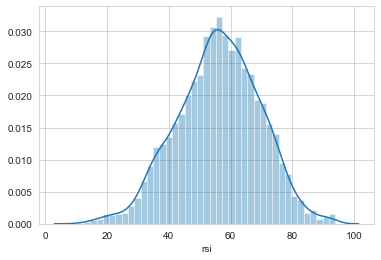

In [11]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [12]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [13]:
prices = (prices.join(prices
                      .groupby(level='Ticker')
                      .Close
                      .apply(compute_bb)))

In [14]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5522 entries, ('BE', Timestamp('2019-01-07 00:00:00')) to ('VWSYF', Timestamp('2020-12-31 00:00:00'))
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     5522 non-null   float64
 1   High     5522 non-null   float64
 2   Low      5522 non-null   float64
 3   Close    5522 non-null   float64
 4   Volume   5522 non-null   int64  
 5   rsi      5368 non-null   float64
 6   bb_high  5313 non-null   float64
 7   bb_mid   5313 non-null   float64
 8   bb_low   5313 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 568.6+ KB


In [15]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,5313.000000,5313.000000,5313.000000
mean,3.681155,3.565432,3.449708
std,1.084951,1.100564,1.123592
min,0.926910,0.842384,0.673113
25%,3.022453,2.879058,2.747568
50%,4.007232,3.926280,3.850049
75%,4.436697,4.353777,4.289960
max,5.907444,5.710831,5.580956


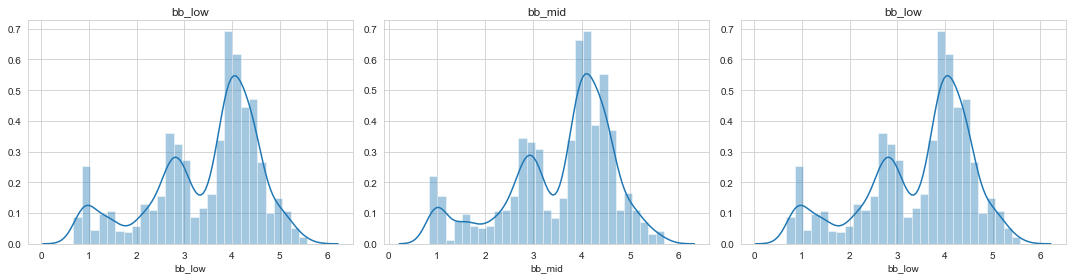

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [17]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.Close))
prices['bb_down'] = np.log1p(prices.Close).sub(prices.bb_low)

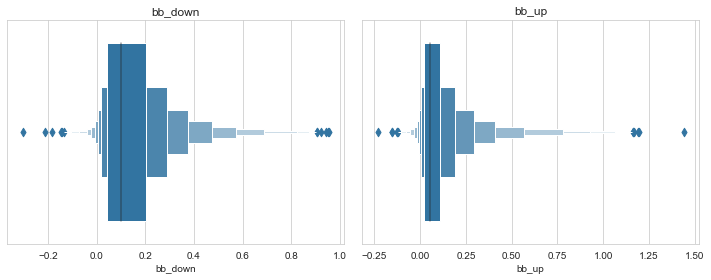

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [19]:
by_ticker = prices.groupby('Ticker', group_keys=False)

In [20]:
def compute_atr(stock_data):
    atr = ATR(stock_data.High, 
              stock_data.Low, 
              stock_data.Close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [21]:
prices['atr'] = by_ticker.apply(compute_atr)

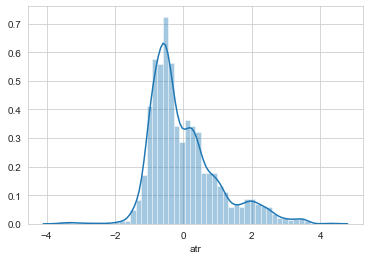

In [22]:
sns.distplot(prices.atr);

In [23]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.High, low=x.Low, close=x.Close))

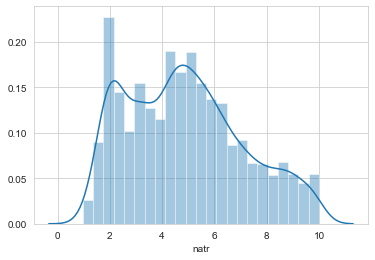

In [24]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [25]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='Ticker').Close.apply(compute_macd)

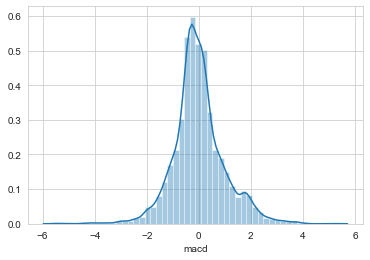

In [26]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [27]:
prices['dollar_volume'] = (prices.loc[:, 'Close']
                           .mul(prices.loc[:, 'Volume'], axis=0))

prices.dollar_volume /= 1e6

In [28]:
prices.to_hdf('data.h5', 'us/Alt_Energy/prices')

In [29]:
prices = pd.read_hdf('data.h5', 'us/Alt_Energy/prices')
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5522 entries, ('BE', Timestamp('2019-01-07 00:00:00')) to ('VWSYF', Timestamp('2020-12-31 00:00:00'))
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           5522 non-null   float64
 1   High           5522 non-null   float64
 2   Low            5522 non-null   float64
 3   Close          5522 non-null   float64
 4   Volume         5522 non-null   int64  
 5   rsi            5368 non-null   float64
 6   bb_high        5313 non-null   float64
 7   bb_mid         5313 non-null   float64
 8   bb_low         5313 non-null   float64
 9   bb_up          5313 non-null   float64
 10  bb_down        5313 non-null   float64
 11  atr            5368 non-null   float64
 12  natr           5368 non-null   float64
 13  macd           5159 non-null   float64
 14  dollar_volume  5522 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 667.4+ KB


## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [30]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'Volume',
                                                              'Open', 'High', 'Low']]

In [31]:
prices = prices.unstack('Ticker')

In [32]:
data = (pd.concat([prices.dollar_volume.resample('D').mean().stack('Ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('D').last().stack('Ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5159 entries, ('BE', Timestamp('2019-02-25 00:00:00', freq='D')) to ('VWSYF', Timestamp('2020-12-31 00:00:00', freq='D'))
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar_volume  5159 non-null   float64
 1   Close          5159 non-null   float64
 2   atr            5159 non-null   float64
 3   bb_down        5159 non-null   float64
 4   bb_high        5159 non-null   float64
 5   bb_low         5159 non-null   float64
 6   bb_mid         5159 non-null   float64
 7   bb_up          5159 non-null   float64
 8   macd           5159 non-null   float64
 9   natr           5159 non-null   float64
 10  rsi            5159 non-null   float64
dtypes: float64(11)
memory usage: 464.3+ KB


## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [34]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [35]:
for lag in lags:
    returns.append(data
                   .Close
                   .unstack('Ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('Ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5148 entries, ('BE', Timestamp('2019-02-26 00:00:00')) to ('VWSYF', Timestamp('2020-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   5148 non-null   float64
 1   return_3m   5126 non-null   float64
 2   return_6m   5093 non-null   float64
 3   return_12m  5027 non-null   float64
dtypes: float64(4)
memory usage: 179.8+ KB


In [36]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,5148.000000,5126.000000,5093.000000,5027.000000
mean,0.003313,0.003010,0.002904,0.002666
std,0.037087,0.022714,0.016471,0.011868
min,-0.115599,-0.066615,-0.050863,-0.036434
25%,-0.013119,-0.007105,-0.004562,-0.002712
50%,0.001282,0.001937,0.001986,0.002161
75%,0.019083,0.012563,0.010137,0.008453
max,0.131982,0.087420,0.056554,0.037776


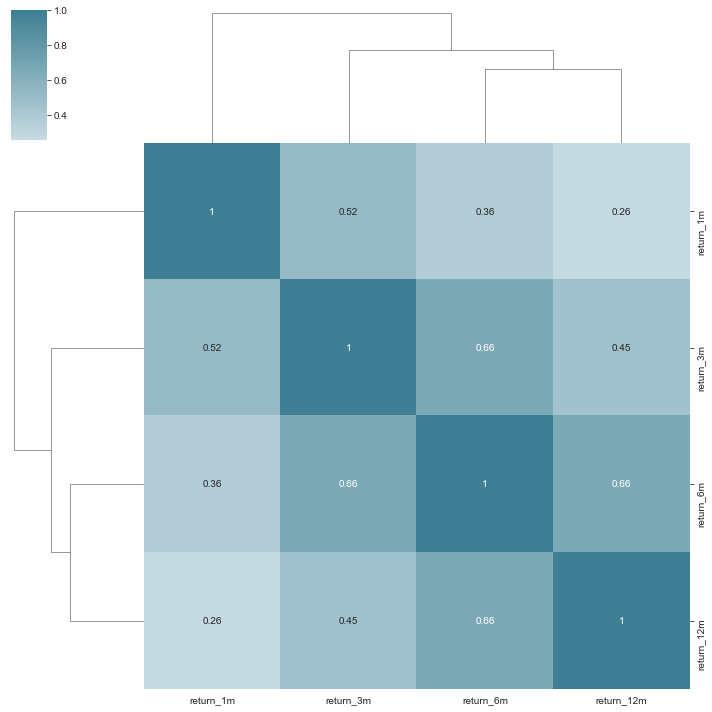

In [37]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [38]:
data = data.join(returns).drop('Close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5027 entries, ('BE', Timestamp('2019-03-13 00:00:00', freq='D')) to ('VWSYF', Timestamp('2020-12-31 00:00:00', freq='D'))
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar_volume  5027 non-null   float64
 1   atr            5027 non-null   float64
 2   bb_down        5027 non-null   float64
 3   bb_high        5027 non-null   float64
 4   bb_low         5027 non-null   float64
 5   bb_mid         5027 non-null   float64
 6   bb_up          5027 non-null   float64
 7   macd           5027 non-null   float64
 8   natr           5027 non-null   float64
 9   rsi            5027 non-null   float64
 10  return_1m      5027 non-null   float64
 11  return_3m      5027 non-null   float64
 12  return_6m      5027 non-null   float64
 13  return_12m     5027 non-null   float64
dtypes: float64(14)
memory usage: 570.4+ KB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [39]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [40]:
dates = data.index.get_level_values('Date')
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [41]:
data['target'] = data.groupby(level='Ticker')[f'return_1m'].shift(-1)

In [42]:
data = data.dropna()

In [43]:
data.sort_index().info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5016 entries, ('BE', Timestamp('2019-03-13 00:00:00', freq='D')) to ('VWSYF', Timestamp('2020-12-30 00:00:00', freq='D'))
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar_volume  5016 non-null   float64
 1   atr            5016 non-null   float64
 2   bb_down        5016 non-null   float64
 3   bb_high        5016 non-null   float64
 4   bb_low         5016 non-null   float64
 5   bb_mid         5016 non-null   float64
 6   bb_up          5016 non-null   float64
 7   macd           5016 non-null   float64
 8   natr           5016 non-null   float64
 9   rsi            5016 non-null   float64
 10  return_1m      5016 non-null   float64
 11  return_3m      5016 non-null   float64
 12  return_6m      5016 non-null   float64
 13  return_12m     5016 non-null   float64
 14  momentum_3     5016 non-null   float64
 15  momentum_6     5016 non-null   float64
 16

## Store data

In [44]:
data.to_hdf

<bound method NDFrame.to_hdf of                    dollar_volume       atr   bb_down   bb_high    bb_low  \
Ticker Date                                                                
BE     2019-03-13      19.570596  0.416073  0.182902  2.873029  2.475257   
BWEN   2019-03-13       0.053295 -0.581117  0.152171  1.041694  0.822389   
CSIQ   2019-03-13      24.365068 -0.270088  0.126628  3.290714  3.078555   
DOGEF  2019-03-13       0.106636  2.331086  0.298246  4.352097  4.047742   
ENPH   2019-03-13      16.462368 -1.073724  0.247639  2.364287  2.090313   
...                          ...       ...       ...       ...       ...   
NEE    2020-12-30     288.822383 -1.821301  0.044166  4.343698  4.298470   
RUN    2020-12-30     220.290167  2.037334  0.210406  4.282505  4.014967   
SEDG   2020-12-30     201.128734  1.929745  0.198906  5.836559  5.569727   
SIEGY  2020-12-30       5.383500 -3.577563  0.069147  4.306229  4.218294   
VWSYF  2020-12-30       0.761216  2.564471  0.235907  5.

In [45]:
with pd.HDFStore('data.h5') as store:
    store.put('us/Alt_Energy/daily', data)

## Evaluate mutual information

In [46]:
X = data.drop('target', axis=1)

In [47]:
mi = mutual_info_regression(X=X, y=data.target)

In [48]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

bb_high          0.126642
bb_low           0.106867
bb_mid           0.105825
natr             0.099955
momentum_3       0.054345
momentum_6       0.053566
return_6m        0.051701
dollar_volume    0.050391
return_12m       0.047426
return_3m        0.046286
dtype: float64

In [49]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [50]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

bb_low         0.012162
momentum_6     0.010063
macd           0.009067
rsi            0.008189
bb_down        0.007661
return_3m      0.007545
bb_high        0.007460
bb_up          0.006987
month          0.006025
momentum_12    0.004105
dtype: float64

In [51]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [52]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

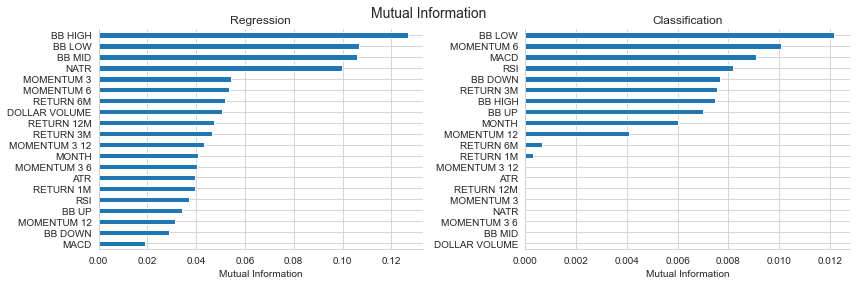

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)